# Training U-Net for Image Segmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils.utils as utils
import torch
from torch.utils.data import DataLoader
import utils.load_dataset as loader
from collections import Counter
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF
from glob import glob
from torchvision.transforms import v2
from torchgeo.models import resnet18
from torchgeo.models import ResNet18_Weights
from torchsummary import summary
import utils.train as t
import model.unet as model
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau

/home/ubuntu/miniconda3/envs/conda_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# for GPU use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Loading Dataset

In [4]:
image_paths = sorted(glob("data/patches/images/*.npy"))
mask_paths = sorted(glob("data/patches/masks/*.npy"))
dataset = loader.SatelliteDataset(image_paths, mask_paths)
print(len(dataset))

4315


## Data Preprocessing

### Data Exploration
Explore Ground Truth mask 

Tree cover (0): 114844614 pixels
Shrubland (1): 7448541 pixels
Grassland (2): 47982258 pixels
Cropland (3): 64127642 pixels
Built-up (4): 5384116 pixels
Bare/sparse veg. (5): 1242573 pixels
Permanent water bodies (7): 49619945 pixels
Herbaceous wetland (8): 116839 pixels


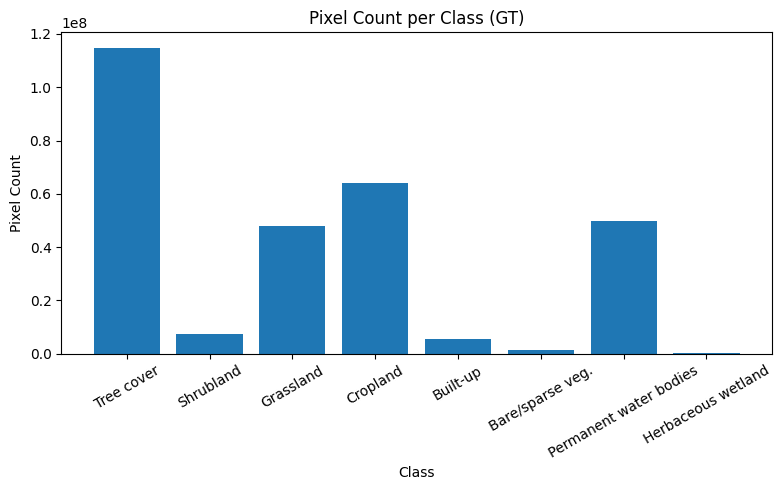

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

class_names = {
    0: "Tree cover",
    1: "Shrubland",
    2: "Grassland",
    3: "Cropland",
    4: "Built-up",
    5: "Bare/sparse veg.",
    6: "Snow and ice",
    7: "Permanent water bodies",
    8: "Herbaceous wetland",
    9: "Mangroves",
    10: "Moss/lichen",
}
label_mapping = {
    10: 0,
    20: 1,
    30: 2,
    40: 3,
    50: 4,
    60: 5,
    70: 6,
    80: 7,
    90: 8,
    95: 9,
    100: 10,
}

gt_path = "data/ground_truth/GBDA24_ex2_ref_data.tif"
with rasterio.open(gt_path) as src:
    raw_mask = src.read(1)

mask = np.full(raw_mask.shape, fill_value=-1, dtype=np.int16)

for raw_val, new_val in label_mapping.items():
    mask[raw_mask == raw_val] = new_val

mask = mask[mask != -1]

unique_classes, counts = np.unique(mask, return_counts=True)
labels = [class_names[c] for c in unique_classes]

for c, count in zip(unique_classes, counts):
    print(f"{class_names[c]} ({c}): {count} pixels")

# Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, counts)
plt.title("Pixel Count per Class (GT)")
plt.ylabel("Pixel Count")
plt.xlabel("Class")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Explore dataset's Ground Truth masks

Tree cover (0): 111331204 pixels
Shrubland (1): 7123964 pixels
Grassland (2): 46763037 pixels
Cropland (3): 62912266 pixels
Built-up (4): 5263554 pixels
Bare/sparse veg. (5): 1225148 pixels
Water bodies (6): 47433889 pixels
Wetland (7): 116595 pixels
Class 255 (255): 618183 pixels


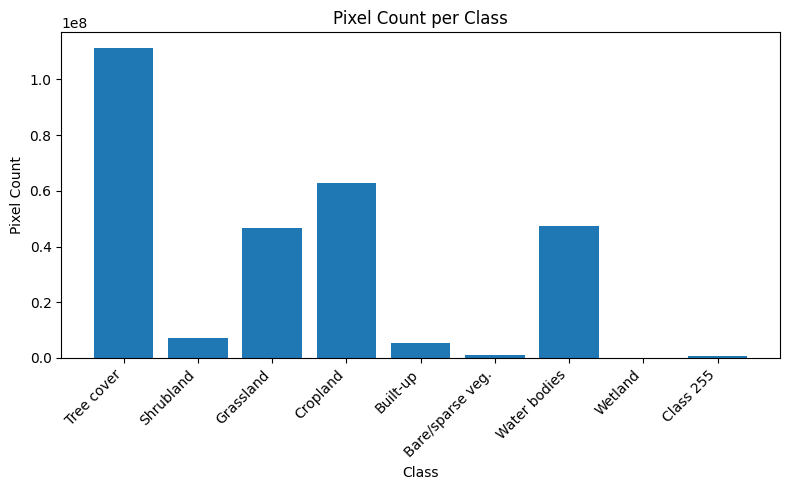

In [23]:
pixel_class_counts = Counter()
for i in range(len(dataset)):
    _, mask = dataset[i]

    if hasattr(mask, "numpy"):
        mask = mask.numpy()
    class_counts = Counter(mask.flatten())
    pixel_class_counts.update(class_counts)

class_names = {
    0: "Tree cover",
    1: "Shrubland",
    2: "Grassland",
    3: "Cropland",
    4: "Built-up",
    5: "Bare/sparse veg.",
    6: "Water bodies",
    7: "Wetland",
}

# Create lists for plotting
classes = sorted(pixel_class_counts.keys())
counts = [pixel_class_counts[c] for c in classes]
labels = [class_names.get(c, f"Class {c}") for c in classes]

for cls_id, count in zip(classes, counts):
    label = class_names.get(cls_id, f"Class {cls_id}")
    print(f"{label} ({cls_id}): {count} pixels")

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts)
plt.title("Pixel Count per Class")
plt.xlabel("Class")
plt.ylabel("Pixel Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

#### Weighted Sampling for balancing dataset

In [6]:
all_indices = list(range(len(dataset)))
train_indices, val_indices = train_test_split(
    all_indices, test_size=0.2, random_state=42
)

### Normalization and Augmentation

In [7]:
# we apply augmentation only in the training dataset
train_transform = loader.Compose(
    [
        loader.RandomHorizontalFlip(),
        loader.RandomRotation(),
        loader.AddGaussianNoise(0.02),
        loader.Normalize13Band(),
        loader.RandomGaussianBlur(kernel_size=3),
    ],
    with_mask=True,
)

val_transform = loader.Compose([loader.Normalize13Band()], with_mask=True)
train_dataset = loader.TorchDataset(Subset(dataset, train_indices), train_transform)
val_dataset = loader.TorchDataset(Subset(dataset, val_indices), val_transform)

In [ ]:
def compute_class_distribution(dataset, num_classes=8, ignore_index=255):
    class_counts = Counter()

    for _, mask in dataset:
        mask_np = mask.numpy().ravel()
        mask_np = mask_np[mask_np != ignore_index]  # exclude ignored pixels
        class_counts.update(mask_np.tolist())

    total = sum(class_counts.values())
    percentages = {
        f"Class {cls}": 100 * count / total
        for cls, count in sorted(class_counts.items())
    }

    return class_counts, percentages


counts, percentages = compute_class_distribution(train_dataset, num_classes=8)

print("=== Class Counts ===")
for cls, count in counts.items():
    print(f"Class {cls}: {count}")

print("\n=== Class Distribution (%) ===")
for cls, pct in percentages.items():
    print(f"{cls}: {pct:.2f}%")

=== Class Counts ===
Class 6: 37447873
Class 2: 37709678
Class 0: 89951581
Class 1: 5898261
Class 3: 49482221
Class 4: 4149342
Class 5: 1004584
Class 7: 83775

=== Class Distribution (%) ===
Class 0: 39.85%
Class 1: 2.61%
Class 2: 16.71%
Class 3: 21.92%
Class 4: 1.84%
Class 5: 0.45%
Class 6: 16.59%
Class 7: 0.04%


In [8]:
val_size = int(0.6 * len(val_dataset))
test_size = len(val_dataset) - val_size

val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])

print(f"Train size: {len(train_dataset)}")
print(f"Val size:   {len(val_dataset)}")
print(f"Test size:  {len(test_dataset)}")

Train size: 3452
Val size:   517
Test size:  346


In [9]:
ds_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
ds_valid = DataLoader(val_dataset, batch_size=32)
ds_test = DataLoader(test_dataset, batch_size=32)

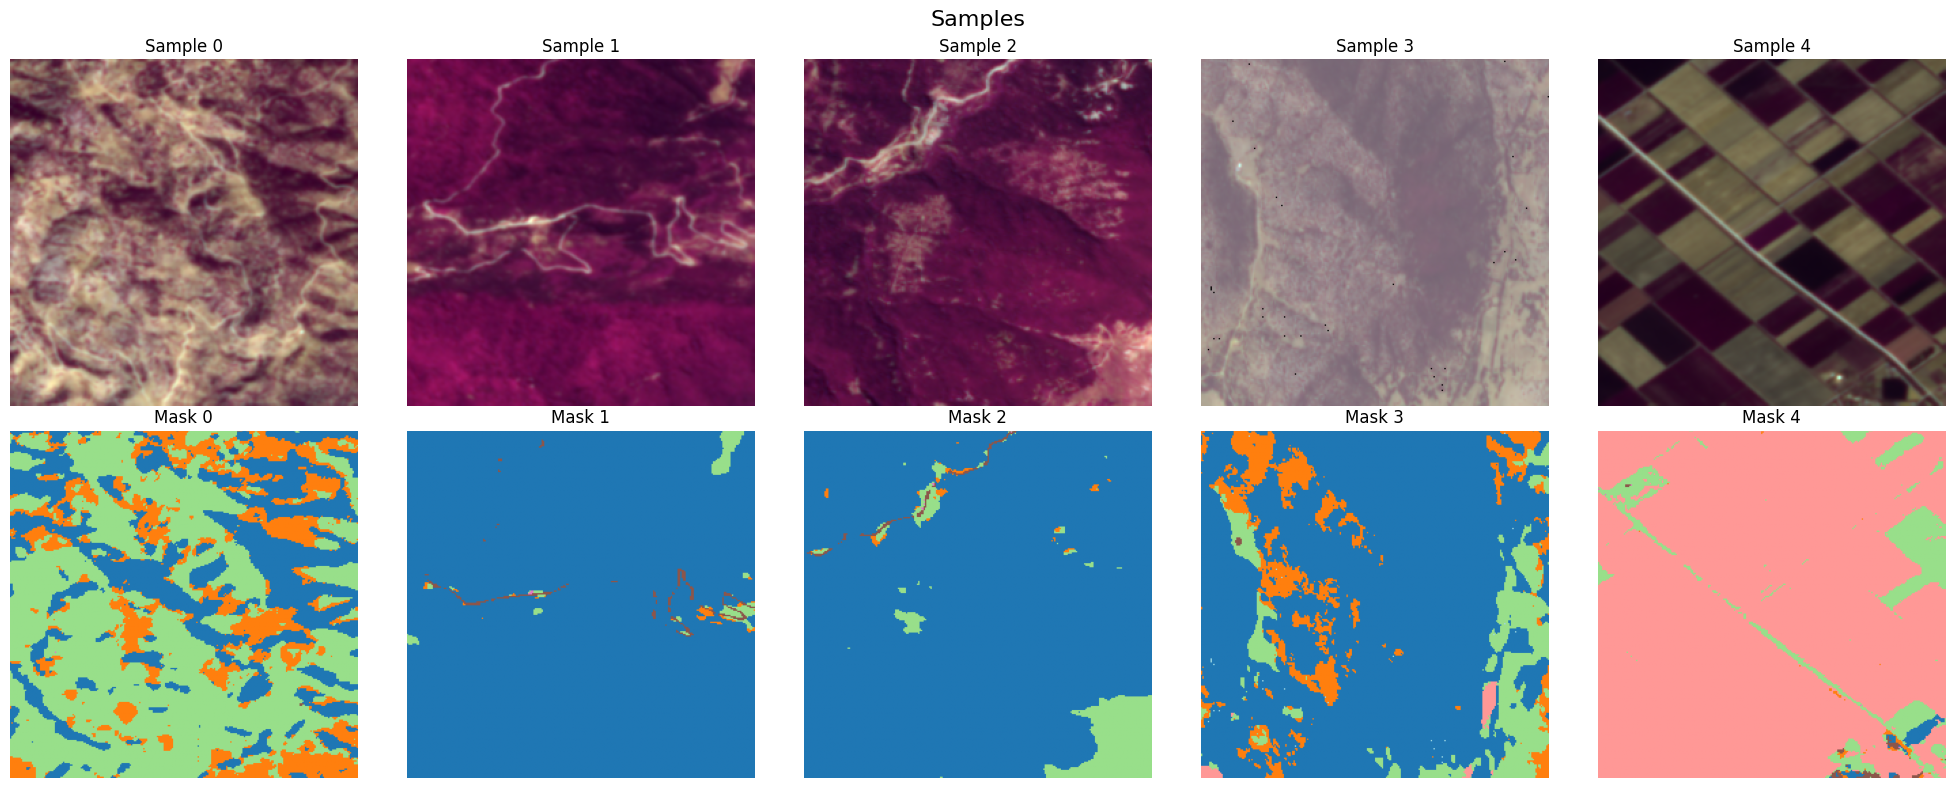

In [25]:
x_batch, y_batch = next(iter(ds_train))  # one batch from training
utils.visualize_samples(
    x_list=[x_batch[i] for i in range(5)],
    y_list=[y_batch[i] for i in range(5)],
    bands=(4, 3, 2),
)

## Model Training

In [12]:
# Architecture of base model

torch.cuda.empty_cache()

resnet = resnet18(ResNet18_Weights.SENTINEL2_ALL_MOCO, pretrained=True)
resnet.to(device)

summary(resnet, input_size=(13, 256, 256))

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv1 pretrained weights from 3 to 13 channel(s)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]          40,768
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
          Identity-7           [-1, 64, 64, 64]               0
              ReLU-8           [-1, 64, 64, 64]               0
          Identity-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
       BasicBlock-13           [-1, 64, 64, 64]               0
           Conv2d-14           [-1, 64,

Due to the dataset's inbalance, weights are going to be used in Loss Function

#### 1st Experiment: Freezing the encoder and train only the decoder using different Loss Functions

#### Using Cross Entropy Loss

Epoch 1/1000 [Val]: 100%|██████████| 17/17 [00:20<00:00,  1.21s/it]


Epoch 1/1000 | Train Loss: 0.6288 | Train Dice: 0.4526 || Train IoU: 0.3885 || Val Loss: 0.4635 | Val Dice: 0.4969 |Val IoU: 0.4302  
New best loss: 0.4635


Epoch 2/1000 [Val]: 100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


Epoch 2/1000 | Train Loss: 0.4095 | Train Dice: 0.5413 || Train IoU: 0.4603 || Val Loss: 0.3933 | Val Dice: 0.5414 |Val IoU: 0.4597  
New best loss: 0.3933


Epoch 3/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]


Epoch 3/1000 | Train Loss: 0.3778 | Train Dice: 0.5933 || Train IoU: 0.4990 || Val Loss: 0.3519 | Val Dice: 0.5914 |Val IoU: 0.4996  
New best loss: 0.3519


Epoch 4/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.53it/s]


Epoch 4/1000 | Train Loss: 0.3686 | Train Dice: 0.6006 || Train IoU: 0.5055 || Val Loss: 0.3546 | Val Dice: 0.5567 |Val IoU: 0.4715  
 No improvement (1/5)


Epoch 5/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.55it/s]


Epoch 5/1000 | Train Loss: 0.3621 | Train Dice: 0.6107 || Train IoU: 0.5140 || Val Loss: 0.3889 | Val Dice: 0.5655 |Val IoU: 0.4750  
 No improvement (2/5)


Epoch 6/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.57it/s]


Epoch 6/1000 | Train Loss: 0.3497 | Train Dice: 0.6142 || Train IoU: 0.5191 || Val Loss: 0.3326 | Val Dice: 0.6081 |Val IoU: 0.5123  
New best loss: 0.3326


Epoch 7/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]


Epoch 7/1000 | Train Loss: 0.3461 | Train Dice: 0.6215 || Train IoU: 0.5248 || Val Loss: 0.3397 | Val Dice: 0.6199 |Val IoU: 0.5230  
 No improvement (1/5)


Epoch 8/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]


Epoch 8/1000 | Train Loss: 0.3494 | Train Dice: 0.6197 || Train IoU: 0.5229 || Val Loss: 0.3166 | Val Dice: 0.6200 |Val IoU: 0.5243  
New best loss: 0.3166


Epoch 9/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.54it/s]


Epoch 9/1000 | Train Loss: 0.3395 | Train Dice: 0.6262 || Train IoU: 0.5295 || Val Loss: 0.3154 | Val Dice: 0.6206 |Val IoU: 0.5272  
New best loss: 0.3154


Epoch 10/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]


Epoch 10/1000 | Train Loss: 0.3329 | Train Dice: 0.6311 || Train IoU: 0.5348 || Val Loss: 0.3221 | Val Dice: 0.6133 |Val IoU: 0.5221  
 No improvement (1/5)


Epoch 11/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]


Epoch 11/1000 | Train Loss: 0.3267 | Train Dice: 0.6332 || Train IoU: 0.5366 || Val Loss: 0.3225 | Val Dice: 0.6122 |Val IoU: 0.5177  
 No improvement (2/5)


Epoch 12/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]


Epoch 12/1000 | Train Loss: 0.3316 | Train Dice: 0.6330 || Train IoU: 0.5366 || Val Loss: 0.3133 | Val Dice: 0.6245 |Val IoU: 0.5268  
New best loss: 0.3133


Epoch 13/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]


Epoch 13/1000 | Train Loss: 0.3234 | Train Dice: 0.6352 || Train IoU: 0.5389 || Val Loss: 0.3162 | Val Dice: 0.6359 |Val IoU: 0.5373  
 No improvement (1/5)


Epoch 14/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.16it/s]


Epoch 14/1000 | Train Loss: 0.3232 | Train Dice: 0.6362 || Train IoU: 0.5398 || Val Loss: 0.3126 | Val Dice: 0.6068 |Val IoU: 0.5143  
 No improvement (2/5)


Epoch 15/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]


Epoch 15/1000 | Train Loss: 0.3200 | Train Dice: 0.6391 || Train IoU: 0.5428 || Val Loss: 0.3076 | Val Dice: 0.6203 |Val IoU: 0.5272  
New best loss: 0.3076


Epoch 16/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.20it/s]


Epoch 16/1000 | Train Loss: 0.3191 | Train Dice: 0.6391 || Train IoU: 0.5432 || Val Loss: 0.3117 | Val Dice: 0.6369 |Val IoU: 0.5388  
 No improvement (1/5)


Epoch 17/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]


Epoch 17/1000 | Train Loss: 0.3159 | Train Dice: 0.6431 || Train IoU: 0.5461 || Val Loss: 0.3021 | Val Dice: 0.6249 |Val IoU: 0.5318  
New best loss: 0.3021


Epoch 18/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]


Epoch 18/1000 | Train Loss: 0.3178 | Train Dice: 0.6430 || Train IoU: 0.5463 || Val Loss: 0.3152 | Val Dice: 0.6378 |Val IoU: 0.5388  
 No improvement (1/5)


Epoch 19/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]


Epoch 19/1000 | Train Loss: 0.3188 | Train Dice: 0.6409 || Train IoU: 0.5439 || Val Loss: 0.3443 | Val Dice: 0.6245 |Val IoU: 0.5232  
 No improvement (2/5)


Epoch 20/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]


Epoch 20/1000 | Train Loss: 0.3141 | Train Dice: 0.6456 || Train IoU: 0.5478 || Val Loss: 0.3058 | Val Dice: 0.6533 |Val IoU: 0.5518  
 No improvement (3/5)


Epoch 21/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]


Epoch 21/1000 | Train Loss: 0.3040 | Train Dice: 0.6597 || Train IoU: 0.5600 || Val Loss: 0.2915 | Val Dice: 0.6482 |Val IoU: 0.5491  
New best loss: 0.2915


Epoch 22/1000 [Val]: 100%|██████████| 17/17 [00:12<00:00,  1.32it/s]


Epoch 22/1000 | Train Loss: 0.3001 | Train Dice: 0.6640 || Train IoU: 0.5633 || Val Loss: 0.2933 | Val Dice: 0.6481 |Val IoU: 0.5464  
 No improvement (1/5)


Epoch 23/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  4.77it/s]


Epoch 23/1000 | Train Loss: 0.3008 | Train Dice: 0.6642 || Train IoU: 0.5632 || Val Loss: 0.2895 | Val Dice: 0.6467 |Val IoU: 0.5459  
New best loss: 0.2895


Epoch 24/1000 [Val]: 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


Epoch 24/1000 | Train Loss: 0.2990 | Train Dice: 0.6665 || Train IoU: 0.5647 || Val Loss: 0.2875 | Val Dice: 0.6622 |Val IoU: 0.5565  
New best loss: 0.2875


Epoch 25/1000 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch 25/1000 | Train Loss: 0.2973 | Train Dice: 0.6750 || Train IoU: 0.5703 || Val Loss: 0.2862 | Val Dice: 0.6729 |Val IoU: 0.5649  
New best loss: 0.2862


Epoch 26/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  4.64it/s]


Epoch 26/1000 | Train Loss: 0.2986 | Train Dice: 0.6760 || Train IoU: 0.5704 || Val Loss: 0.2875 | Val Dice: 0.6699 |Val IoU: 0.5620  
 No improvement (1/5)


Epoch 27/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.19it/s]


Epoch 27/1000 | Train Loss: 0.2981 | Train Dice: 0.6860 || Train IoU: 0.5763 || Val Loss: 0.2895 | Val Dice: 0.6818 |Val IoU: 0.5703  
 No improvement (2/5)


Epoch 28/1000 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.74it/s]


Epoch 28/1000 | Train Loss: 0.2980 | Train Dice: 0.6940 || Train IoU: 0.5822 || Val Loss: 0.2922 | Val Dice: 0.6899 |Val IoU: 0.5743  
 No improvement (3/5)


Epoch 29/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]


Epoch 29/1000 | Train Loss: 0.2919 | Train Dice: 0.7083 || Train IoU: 0.5942 || Val Loss: 0.2836 | Val Dice: 0.6813 |Val IoU: 0.5703  
New best loss: 0.2836


Epoch 30/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]


Epoch 30/1000 | Train Loss: 0.2938 | Train Dice: 0.6978 || Train IoU: 0.5859 || Val Loss: 0.2862 | Val Dice: 0.6796 |Val IoU: 0.5693  
 No improvement (1/5)


Epoch 31/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]


Epoch 31/1000 | Train Loss: 0.2912 | Train Dice: 0.7093 || Train IoU: 0.5950 || Val Loss: 0.2874 | Val Dice: 0.6751 |Val IoU: 0.5646  
 No improvement (2/5)


Epoch 32/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]


Epoch 32/1000 | Train Loss: 0.2884 | Train Dice: 0.7134 || Train IoU: 0.5987 || Val Loss: 0.2807 | Val Dice: 0.6827 |Val IoU: 0.5727  
New best loss: 0.2807


Epoch 33/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.37it/s]


Epoch 33/1000 | Train Loss: 0.2896 | Train Dice: 0.7072 || Train IoU: 0.5939 || Val Loss: 0.2825 | Val Dice: 0.6831 |Val IoU: 0.5708  
 No improvement (1/5)


Epoch 34/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]


Epoch 34/1000 | Train Loss: 0.2876 | Train Dice: 0.7102 || Train IoU: 0.5965 || Val Loss: 0.2840 | Val Dice: 0.6808 |Val IoU: 0.5704  
 No improvement (2/5)


Epoch 35/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]


Epoch 35/1000 | Train Loss: 0.2878 | Train Dice: 0.7110 || Train IoU: 0.5966 || Val Loss: 0.2888 | Val Dice: 0.6869 |Val IoU: 0.5734  
 No improvement (3/5)


Epoch 36/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]


Epoch 36/1000 | Train Loss: 0.2837 | Train Dice: 0.7184 || Train IoU: 0.6036 || Val Loss: 0.2780 | Val Dice: 0.6960 |Val IoU: 0.5828  
New best loss: 0.2780


Epoch 37/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]


Epoch 37/1000 | Train Loss: 0.2839 | Train Dice: 0.7190 || Train IoU: 0.6039 || Val Loss: 0.2786 | Val Dice: 0.6991 |Val IoU: 0.5850  
 No improvement (1/5)


Epoch 38/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]


Epoch 38/1000 | Train Loss: 0.2829 | Train Dice: 0.7251 || Train IoU: 0.6092 || Val Loss: 0.2781 | Val Dice: 0.6993 |Val IoU: 0.5845  
 No improvement (2/5)


Epoch 39/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.62it/s]


Epoch 39/1000 | Train Loss: 0.2832 | Train Dice: 0.7229 || Train IoU: 0.6074 || Val Loss: 0.2804 | Val Dice: 0.7069 |Val IoU: 0.5906  
 No improvement (3/5)


Epoch 40/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]


Epoch 40/1000 | Train Loss: 0.2829 | Train Dice: 0.7243 || Train IoU: 0.6084 || Val Loss: 0.2767 | Val Dice: 0.7018 |Val IoU: 0.5871  
New best loss: 0.2767


Epoch 41/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]


Epoch 41/1000 | Train Loss: 0.2805 | Train Dice: 0.7277 || Train IoU: 0.6115 || Val Loss: 0.2762 | Val Dice: 0.7074 |Val IoU: 0.5918  
 No improvement (1/5)


Epoch 42/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]


Epoch 42/1000 | Train Loss: 0.2797 | Train Dice: 0.7259 || Train IoU: 0.6103 || Val Loss: 0.2771 | Val Dice: 0.7100 |Val IoU: 0.5934  
 No improvement (2/5)


Epoch 43/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]


Epoch 43/1000 | Train Loss: 0.2796 | Train Dice: 0.7301 || Train IoU: 0.6140 || Val Loss: 0.2741 | Val Dice: 0.7052 |Val IoU: 0.5906  
New best loss: 0.2741


Epoch 44/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]


Epoch 44/1000 | Train Loss: 0.2796 | Train Dice: 0.7303 || Train IoU: 0.6143 || Val Loss: 0.2768 | Val Dice: 0.7113 |Val IoU: 0.5949  
 No improvement (1/5)


Epoch 45/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]


Epoch 45/1000 | Train Loss: 0.2796 | Train Dice: 0.7314 || Train IoU: 0.6153 || Val Loss: 0.2749 | Val Dice: 0.7078 |Val IoU: 0.5925  
 No improvement (2/5)


Epoch 46/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.37it/s]


Epoch 46/1000 | Train Loss: 0.2796 | Train Dice: 0.7270 || Train IoU: 0.6113 || Val Loss: 0.2753 | Val Dice: 0.7099 |Val IoU: 0.5936  
 No improvement (3/5)


Epoch 47/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]


Epoch 47/1000 | Train Loss: 0.2779 | Train Dice: 0.7340 || Train IoU: 0.6177 || Val Loss: 0.2739 | Val Dice: 0.7129 |Val IoU: 0.5968  
 No improvement (4/5)


Epoch 48/1000 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]


Epoch 48/1000 | Train Loss: 0.2769 | Train Dice: 0.7305 || Train IoU: 0.6148 || Val Loss: 0.2745 | Val Dice: 0.7139 |Val IoU: 0.5975  
 No improvement (5/5)
Early stopping triggered.


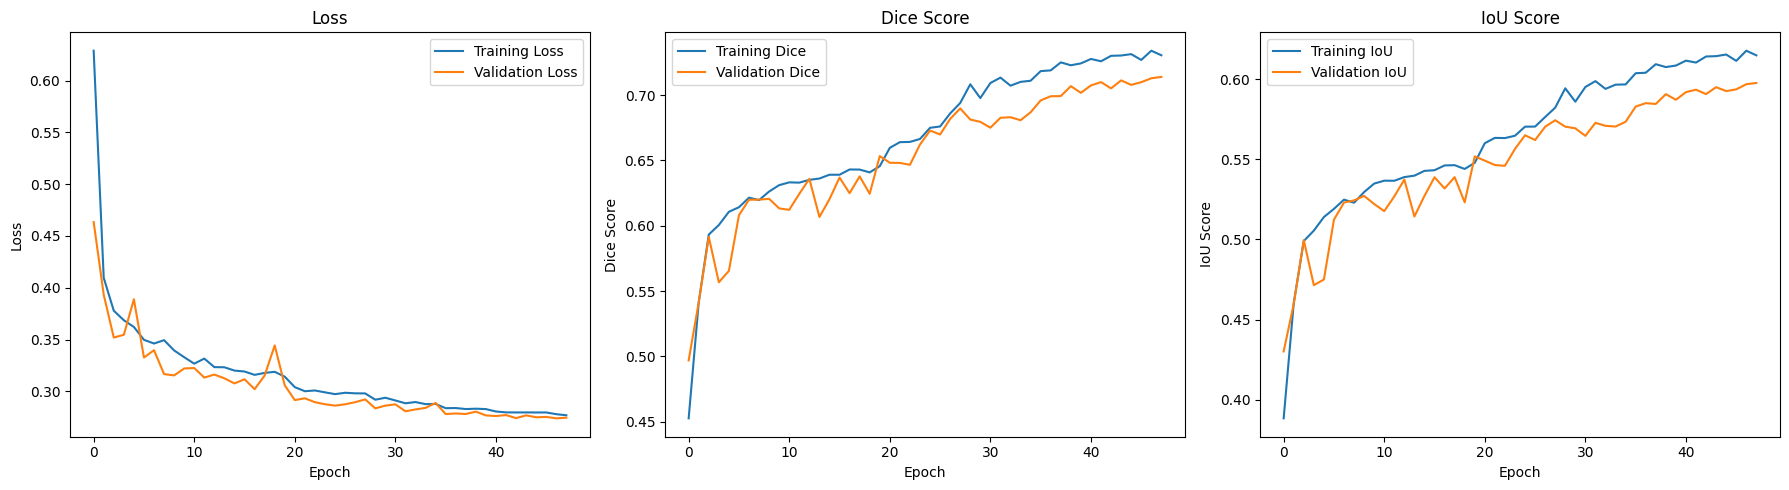

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0     0.9107    0.9398    0.9251  12879051
     Class 1     0.5868    0.2555    0.3560    741343
     Class 2     0.7700    0.7656    0.7678   5359069
     Class 3     0.9020    0.9179    0.9099   8173775
     Class 4     0.7107    0.6392    0.6730    638444
     Class 5     0.6212    0.5393    0.5774    116503
     Class 6     0.9864    0.9969    0.9917   5870613
     Class 7     0.7695    0.3758    0.5050     28529

   micro avg     0.8923    0.8943    0.8933  33807327
   macro avg     0.7822    0.6788    0.7132  33807327
weighted avg     0.8875    0.8943    0.8892  33807327

=== Dice per Class ===
0: 0.9251
1: 0.3560
2: 0.7678
3: 0.9099
4: 0.6730
5: 0.5774
6: 0.9917
7: 0.5050

=== IoU per Class ===
0: 0.8606
1: 0.2165
2: 0.6232
3: 0.8347
4: 0.5072
5: 0.4058
6: 0.9835
7: 0.3378

 === Overall Performance === 
Macro-Dice: 0.7132
Macro-IoU : 0.5962


In [ ]:
unet = model.UNet(num_classes=8)
unet = unet.to(device)
for enc in (unet.encoder0, unet.encoder1, unet.encoder2, unet.encoder3, unet.encoder4):
    for p in enc.parameters():
        p.requires_grad = False
    for m in enc.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

ds_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
ds_valid = DataLoader(val_dataset, batch_size=32, shuffle=False)
ds_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

dec_lr = 1e-3

optimizer = optim.Adam(
    [
        {"params": unet.bottleneck.parameters(), "lr": dec_lr},
        {"params": unet.decoder_1.parameters(), "lr": dec_lr},
        {"params": unet.decoder_2.parameters(), "lr": dec_lr},
        {"params": unet.decoder_3.parameters(), "lr": dec_lr},
        {"params": unet.decoder_4.parameters(), "lr": dec_lr},
        {"params": unet.decoder_5.parameters(), "lr": dec_lr},  # ← add this line
        {"params": unet.final.parameters(), "lr": dec_lr},
    ],
    weight_decay=1e-4,  # optional but recommended
)


criterion = nn.CrossEntropyLoss(ignore_index=255)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2,
)
# Train the model
train_losses, val_losses, train_dice, val_dice, train_iou, val_iou = t.train_model(
    model=unet,
    num_classes=8,
    train_loader=ds_train,
    val_loader=ds_valid,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=100,
    save_name="output/cross_entropy.pt",
)

# Evaluate
t.plot_history(train_losses, val_losses, train_dice, val_dice, train_iou, val_iou)
t.segmentation_report(unet, ds_valid)

#### Using Dice Loss

Epoch 1/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]


Epoch 1/100 | Train Loss: 0.6882 | Train Dice: 0.4091 || Train IoU: 0.3269 || Val Loss: 0.5982 | Val Dice: 0.5033 |Val IoU: 0.4244  
New best loss: 0.5982


Epoch 2/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.46it/s]


Epoch 2/100 | Train Loss: 0.5900 | Train Dice: 0.5145 || Train IoU: 0.4297 || Val Loss: 0.5376 | Val Dice: 0.5212 |Val IoU: 0.4367  
New best loss: 0.5376


Epoch 3/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]


Epoch 3/100 | Train Loss: 0.5307 | Train Dice: 0.5891 || Train IoU: 0.4836 || Val Loss: 0.4896 | Val Dice: 0.5947 |Val IoU: 0.4904  
New best loss: 0.4896


Epoch 4/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]


Epoch 4/100 | Train Loss: 0.4823 | Train Dice: 0.6132 || Train IoU: 0.5067 || Val Loss: 0.4385 | Val Dice: 0.6215 |Val IoU: 0.5179  
New best loss: 0.4385


Epoch 5/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]


Epoch 5/100 | Train Loss: 0.4361 | Train Dice: 0.6291 || Train IoU: 0.5235 || Val Loss: 0.4017 | Val Dice: 0.6238 |Val IoU: 0.5199  
New best loss: 0.4017


Epoch 6/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]


Epoch 6/100 | Train Loss: 0.3998 | Train Dice: 0.6390 || Train IoU: 0.5344 || Val Loss: 0.3772 | Val Dice: 0.6361 |Val IoU: 0.5336  
New best loss: 0.3772


Epoch 7/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]


Epoch 7/100 | Train Loss: 0.3917 | Train Dice: 0.6428 || Train IoU: 0.5381 || Val Loss: 0.3638 | Val Dice: 0.6349 |Val IoU: 0.5323  
New best loss: 0.3638


Epoch 8/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]


Epoch 8/100 | Train Loss: 0.3761 | Train Dice: 0.6480 || Train IoU: 0.5441 || Val Loss: 0.3524 | Val Dice: 0.6338 |Val IoU: 0.5311  
New best loss: 0.3524


Epoch 9/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


Epoch 9/100 | Train Loss: 0.3558 | Train Dice: 0.6517 || Train IoU: 0.5483 || Val Loss: 0.3460 | Val Dice: 0.6340 |Val IoU: 0.5317  
New best loss: 0.3460


Epoch 10/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]


Epoch 10/100 | Train Loss: 0.3490 | Train Dice: 0.6552 || Train IoU: 0.5522 || Val Loss: 0.3341 | Val Dice: 0.6439 |Val IoU: 0.5426  
New best loss: 0.3341


Epoch 11/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]


Epoch 11/100 | Train Loss: 0.3500 | Train Dice: 0.6543 || Train IoU: 0.5514 || Val Loss: 0.3288 | Val Dice: 0.6470 |Val IoU: 0.5451  
New best loss: 0.3288


Epoch 12/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]


Epoch 12/100 | Train Loss: 0.3476 | Train Dice: 0.6561 || Train IoU: 0.5534 || Val Loss: 0.3282 | Val Dice: 0.6476 |Val IoU: 0.5464  
 No improvement (1/5)


Epoch 13/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]


Epoch 13/100 | Train Loss: 0.3349 | Train Dice: 0.6724 || Train IoU: 0.5629 || Val Loss: 0.3207 | Val Dice: 0.6756 |Val IoU: 0.5611  
New best loss: 0.3207


Epoch 14/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


Epoch 14/100 | Train Loss: 0.3288 | Train Dice: 0.6835 || Train IoU: 0.5702 || Val Loss: 0.3176 | Val Dice: 0.6922 |Val IoU: 0.5738  
New best loss: 0.3176


Epoch 15/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


Epoch 15/100 | Train Loss: 0.3180 | Train Dice: 0.6915 || Train IoU: 0.5777 || Val Loss: 0.3144 | Val Dice: 0.6975 |Val IoU: 0.5784  
New best loss: 0.3144


Epoch 16/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]


Epoch 16/100 | Train Loss: 0.3169 | Train Dice: 0.7030 || Train IoU: 0.5846 || Val Loss: 0.3113 | Val Dice: 0.7078 |Val IoU: 0.5865  
New best loss: 0.3113


Epoch 17/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]


Epoch 17/100 | Train Loss: 0.3105 | Train Dice: 0.7148 || Train IoU: 0.5947 || Val Loss: 0.3101 | Val Dice: 0.7021 |Val IoU: 0.5815  
New best loss: 0.3101


Epoch 18/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]


Epoch 18/100 | Train Loss: 0.3174 | Train Dice: 0.7087 || Train IoU: 0.5900 || Val Loss: 0.3102 | Val Dice: 0.7154 |Val IoU: 0.5931  
 No improvement (1/5)


Epoch 19/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]


Epoch 19/100 | Train Loss: 0.3158 | Train Dice: 0.7166 || Train IoU: 0.5952 || Val Loss: 0.3087 | Val Dice: 0.7212 |Val IoU: 0.5980  
New best loss: 0.3087


Epoch 20/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]


Epoch 20/100 | Train Loss: 0.3078 | Train Dice: 0.7126 || Train IoU: 0.5932 || Val Loss: 0.3065 | Val Dice: 0.7236 |Val IoU: 0.6009  
New best loss: 0.3065


Epoch 21/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]


Epoch 21/100 | Train Loss: 0.3028 | Train Dice: 0.7320 || Train IoU: 0.6098 || Val Loss: 0.3039 | Val Dice: 0.7290 |Val IoU: 0.6064  
New best loss: 0.3039


Epoch 22/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]


Epoch 22/100 | Train Loss: 0.3176 | Train Dice: 0.7231 || Train IoU: 0.6018 || Val Loss: 0.3041 | Val Dice: 0.7259 |Val IoU: 0.6034  
 No improvement (1/5)


Epoch 23/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]


Epoch 23/100 | Train Loss: 0.3030 | Train Dice: 0.7354 || Train IoU: 0.6134 || Val Loss: 0.3023 | Val Dice: 0.7297 |Val IoU: 0.6070  
New best loss: 0.3023


Epoch 24/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]


Epoch 24/100 | Train Loss: 0.3020 | Train Dice: 0.7262 || Train IoU: 0.6052 || Val Loss: 0.3009 | Val Dice: 0.7160 |Val IoU: 0.5935  
New best loss: 0.3009


Epoch 25/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]


Epoch 25/100 | Train Loss: 0.3008 | Train Dice: 0.7342 || Train IoU: 0.6123 || Val Loss: 0.3013 | Val Dice: 0.7187 |Val IoU: 0.5963  
 No improvement (1/5)


Epoch 26/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]


Epoch 26/100 | Train Loss: 0.3071 | Train Dice: 0.7105 || Train IoU: 0.5936 || Val Loss: 0.3003 | Val Dice: 0.7271 |Val IoU: 0.6046  
 No improvement (2/5)


Epoch 27/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]


Epoch 27/100 | Train Loss: 0.3027 | Train Dice: 0.7345 || Train IoU: 0.6125 || Val Loss: 0.2986 | Val Dice: 0.7170 |Val IoU: 0.5946  
New best loss: 0.2986


Epoch 28/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]


Epoch 28/100 | Train Loss: 0.2954 | Train Dice: 0.7336 || Train IoU: 0.6120 || Val Loss: 0.2997 | Val Dice: 0.7159 |Val IoU: 0.5936  
 No improvement (1/5)


Epoch 29/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]


Epoch 29/100 | Train Loss: 0.2911 | Train Dice: 0.7402 || Train IoU: 0.6184 || Val Loss: 0.2937 | Val Dice: 0.7317 |Val IoU: 0.6096  
New best loss: 0.2937


Epoch 30/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]


Epoch 30/100 | Train Loss: 0.2957 | Train Dice: 0.7305 || Train IoU: 0.6090 || Val Loss: 0.2958 | Val Dice: 0.7257 |Val IoU: 0.6035  
 No improvement (1/5)


Epoch 31/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]


Epoch 31/100 | Train Loss: 0.2957 | Train Dice: 0.7426 || Train IoU: 0.6204 || Val Loss: 0.2945 | Val Dice: 0.7311 |Val IoU: 0.6083  
 No improvement (2/5)


Epoch 32/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]


Epoch 32/100 | Train Loss: 0.2983 | Train Dice: 0.7411 || Train IoU: 0.6191 || Val Loss: 0.2971 | Val Dice: 0.7255 |Val IoU: 0.6030  
 No improvement (3/5)


Epoch 33/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]


Epoch 33/100 | Train Loss: 0.2959 | Train Dice: 0.7505 || Train IoU: 0.6287 || Val Loss: 0.2904 | Val Dice: 0.7312 |Val IoU: 0.6093  
New best loss: 0.2904


Epoch 34/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]


Epoch 34/100 | Train Loss: 0.2853 | Train Dice: 0.7560 || Train IoU: 0.6347 || Val Loss: 0.2900 | Val Dice: 0.7308 |Val IoU: 0.6088  
 No improvement (1/5)


Epoch 35/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]


Epoch 35/100 | Train Loss: 0.2777 | Train Dice: 0.7584 || Train IoU: 0.6373 || Val Loss: 0.2917 | Val Dice: 0.7285 |Val IoU: 0.6067  
 No improvement (2/5)


Epoch 36/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.50it/s]


Epoch 36/100 | Train Loss: 0.2836 | Train Dice: 0.7556 || Train IoU: 0.6344 || Val Loss: 0.2885 | Val Dice: 0.7330 |Val IoU: 0.6110  
New best loss: 0.2885


Epoch 37/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]


Epoch 37/100 | Train Loss: 0.2821 | Train Dice: 0.7594 || Train IoU: 0.6384 || Val Loss: 0.2888 | Val Dice: 0.7384 |Val IoU: 0.6170  
 No improvement (1/5)


Epoch 38/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


Epoch 38/100 | Train Loss: 0.2787 | Train Dice: 0.7604 || Train IoU: 0.6395 || Val Loss: 0.2893 | Val Dice: 0.7371 |Val IoU: 0.6156  
 No improvement (2/5)


Epoch 39/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]


Epoch 39/100 | Train Loss: 0.2831 | Train Dice: 0.7605 || Train IoU: 0.6394 || Val Loss: 0.2890 | Val Dice: 0.7329 |Val IoU: 0.6110  
 No improvement (3/5)


Epoch 40/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]


Epoch 40/100 | Train Loss: 0.2778 | Train Dice: 0.7603 || Train IoU: 0.6393 || Val Loss: 0.2868 | Val Dice: 0.7382 |Val IoU: 0.6165  
New best loss: 0.2868


Epoch 41/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]


Epoch 41/100 | Train Loss: 0.2786 | Train Dice: 0.7629 || Train IoU: 0.6422 || Val Loss: 0.2879 | Val Dice: 0.7385 |Val IoU: 0.6168  
 No improvement (1/5)


Epoch 42/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]


Epoch 42/100 | Train Loss: 0.2782 | Train Dice: 0.7634 || Train IoU: 0.6427 || Val Loss: 0.2885 | Val Dice: 0.7382 |Val IoU: 0.6169  
 No improvement (2/5)


Epoch 43/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]


Epoch 43/100 | Train Loss: 0.2800 | Train Dice: 0.7667 || Train IoU: 0.6464 || Val Loss: 0.2836 | Val Dice: 0.7441 |Val IoU: 0.6227  
New best loss: 0.2836


Epoch 44/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]


Epoch 44/100 | Train Loss: 0.2806 | Train Dice: 0.7657 || Train IoU: 0.6454 || Val Loss: 0.2864 | Val Dice: 0.7319 |Val IoU: 0.6102  
 No improvement (1/5)


Epoch 45/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]


Epoch 45/100 | Train Loss: 0.2800 | Train Dice: 0.7637 || Train IoU: 0.6431 || Val Loss: 0.2860 | Val Dice: 0.7337 |Val IoU: 0.6122  
 No improvement (2/5)


Epoch 46/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


Epoch 46/100 | Train Loss: 0.2754 | Train Dice: 0.7681 || Train IoU: 0.6481 || Val Loss: 0.2844 | Val Dice: 0.7391 |Val IoU: 0.6176  
 No improvement (3/5)


Epoch 47/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]


Epoch 47/100 | Train Loss: 0.2765 | Train Dice: 0.7700 || Train IoU: 0.6502 || Val Loss: 0.2849 | Val Dice: 0.7421 |Val IoU: 0.6207  
 No improvement (4/5)


Epoch 48/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]


Epoch 48/100 | Train Loss: 0.2761 | Train Dice: 0.7695 || Train IoU: 0.6495 || Val Loss: 0.2842 | Val Dice: 0.7434 |Val IoU: 0.6223  
 No improvement (5/5)
Early stopping triggered.


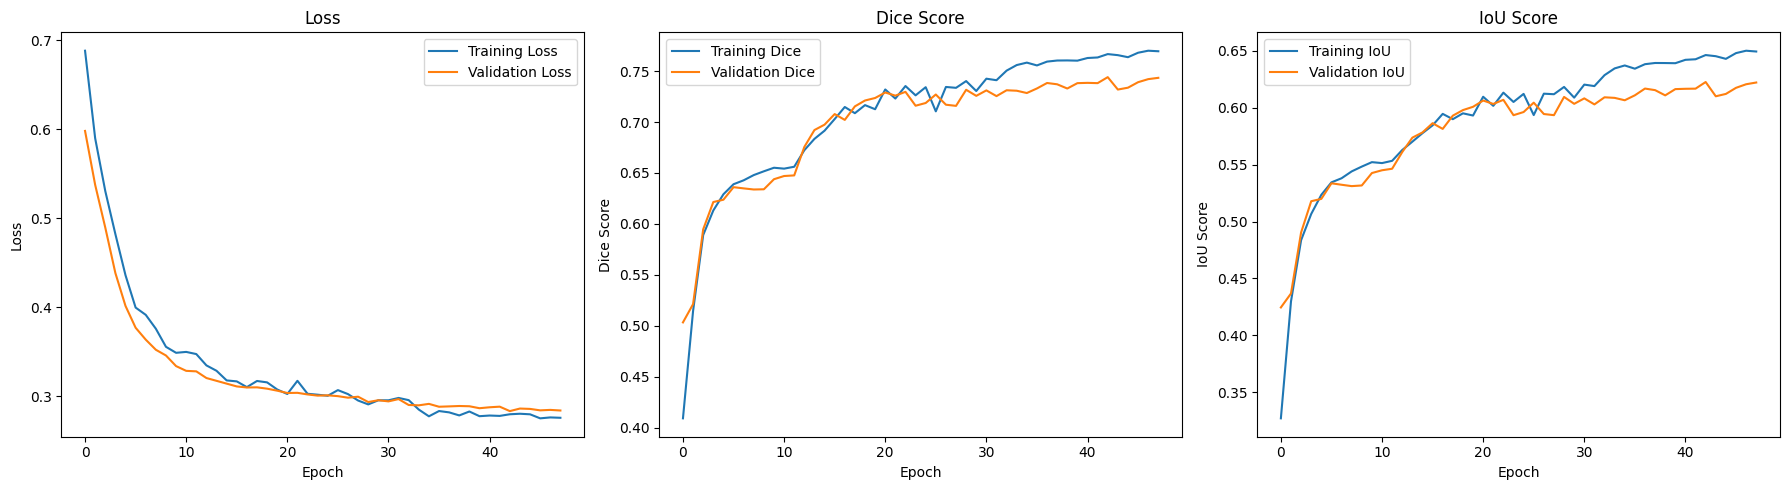

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0     0.9195    0.9126    0.9160  12879051
     Class 1     0.4525    0.4349    0.4435    741343
     Class 2     0.7439    0.7545    0.7492   5359069
     Class 3     0.8954    0.9068    0.9011   8173775
     Class 4     0.6906    0.6541    0.6719    638444
     Class 5     0.5894    0.6622    0.6237    116503
     Class 6     0.9889    0.9962    0.9926   5870613
     Class 7     0.6983    0.5960    0.6431     28529

   micro avg     0.8822    0.8842    0.8832  33807327
   macro avg     0.7473    0.7397    0.7426  33807327
weighted avg     0.8820    0.8842    0.8830  33807327

=== Dice per Class ===
0: 0.9160
1: 0.4435
2: 0.7492
3: 0.9011
4: 0.6719
5: 0.6237
6: 0.9926
7: 0.6431

=== IoU per Class ===
0: 0.8451
1: 0.2850
2: 0.5989
3: 0.8199
4: 0.5059
5: 0.4532
6: 0.9852
7: 0.4739

 === Overall Performance === 
Macro-Dice: 0.7426
Macro-IoU : 0.6209


In [ ]:
unet = model.UNet(num_classes=8)
unet = unet.to(device)
for enc in (unet.encoder0, unet.encoder1, unet.encoder2, unet.encoder3, unet.encoder4):
    for p in enc.parameters():
        p.requires_grad = False
    for m in enc.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

ds_train = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
)
ds_valid = DataLoader(val_dataset, batch_size=32, shuffle=False)
ds_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

dec_lr = 1e-4

optimizer = optim.Adam(
    [
        {"params": unet.bottleneck.parameters(), "lr": dec_lr},
        {"params": unet.decoder_1.parameters(), "lr": dec_lr},
        {"params": unet.decoder_2.parameters(), "lr": dec_lr},
        {"params": unet.decoder_3.parameters(), "lr": dec_lr},
        {"params": unet.decoder_4.parameters(), "lr": dec_lr},
        {"params": unet.decoder_5.parameters(), "lr": dec_lr},
        {"params": unet.final.parameters(), "lr": dec_lr},
    ],
    weight_decay=1e-4,
)


criterion = smp.losses.DiceLoss(mode="multiclass", from_logits=True, ignore_index=255)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2,
)
# Train the model
train_losses, val_losses, train_dice, val_dice, train_iou, val_iou = t.train_model(
    model=unet,
    train_loader=ds_train,
    val_loader=ds_valid,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=100,
    save_name="output/new_dice_loss.pt",
)

# Evaluate
t.plot_history(train_losses, val_losses, train_dice, val_dice, train_iou, val_iou)
t.segmentation_report(unet, ds_valid)

#### Using Dice + CrossEntropy Loss (Hybrid Approach)

In [10]:
class HybridLoss(nn.Module):
    def __init__(self, a):
        super(HybridLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss(ignore_index=255)
        self.dice = smp.losses.DiceLoss(
            mode="multiclass", from_logits=True, ignore_index=255
        )
        self.a = a

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        dice_loss = self.dice(logits, targets)
        return ce_loss + self.a * dice_loss

Epoch 1/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.10it/s]


Epoch 1/100 | Train Loss: 0.8946 | Train Dice: 0.4837 || Train IoU: 0.4104 || Val Loss: 0.6611 | Val Dice: 0.5338 |Val IoU: 0.4580  
New best loss: 0.6611


Epoch 2/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]


Epoch 2/100 | Train Loss: 0.6391 | Train Dice: 0.5940 || Train IoU: 0.4973 || Val Loss: 0.5947 | Val Dice: 0.5995 |Val IoU: 0.5061  
New best loss: 0.5947


Epoch 3/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.43it/s]


Epoch 3/100 | Train Loss: 0.6116 | Train Dice: 0.6146 || Train IoU: 0.5141 || Val Loss: 0.6302 | Val Dice: 0.6018 |Val IoU: 0.5069  
 No improvement (1/5)


Epoch 4/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]


Epoch 4/100 | Train Loss: 0.5766 | Train Dice: 0.6283 || Train IoU: 0.5279 || Val Loss: 0.5592 | Val Dice: 0.6167 |Val IoU: 0.5232  
New best loss: 0.5592


Epoch 5/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]


Epoch 5/100 | Train Loss: 0.5596 | Train Dice: 0.6330 || Train IoU: 0.5328 || Val Loss: 0.5722 | Val Dice: 0.6299 |Val IoU: 0.5274  
 No improvement (1/5)


Epoch 6/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]


Epoch 6/100 | Train Loss: 0.5526 | Train Dice: 0.6352 || Train IoU: 0.5355 || Val Loss: 0.5474 | Val Dice: 0.6409 |Val IoU: 0.5406  
New best loss: 0.5474


Epoch 7/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]


Epoch 7/100 | Train Loss: 0.5470 | Train Dice: 0.6369 || Train IoU: 0.5368 || Val Loss: 0.5485 | Val Dice: 0.6369 |Val IoU: 0.5364  
 No improvement (1/5)


Epoch 8/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]


Epoch 8/100 | Train Loss: 0.5361 | Train Dice: 0.6411 || Train IoU: 0.5417 || Val Loss: 0.5256 | Val Dice: 0.6470 |Val IoU: 0.5478  
New best loss: 0.5256


Epoch 9/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


Epoch 9/100 | Train Loss: 0.5297 | Train Dice: 0.6451 || Train IoU: 0.5452 || Val Loss: 0.5438 | Val Dice: 0.6460 |Val IoU: 0.5447  
 No improvement (1/5)


Epoch 10/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]


Epoch 10/100 | Train Loss: 0.5303 | Train Dice: 0.6696 || Train IoU: 0.5593 || Val Loss: 0.5208 | Val Dice: 0.6710 |Val IoU: 0.5617  
New best loss: 0.5208


Epoch 11/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]


Epoch 11/100 | Train Loss: 0.5162 | Train Dice: 0.6895 || Train IoU: 0.5741 || Val Loss: 0.5241 | Val Dice: 0.6979 |Val IoU: 0.5796  
 No improvement (1/5)


Epoch 12/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]


Epoch 12/100 | Train Loss: 0.5151 | Train Dice: 0.6992 || Train IoU: 0.5818 || Val Loss: 0.5288 | Val Dice: 0.6740 |Val IoU: 0.5624  
 No improvement (2/5)


Epoch 13/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


Epoch 13/100 | Train Loss: 0.5151 | Train Dice: 0.6992 || Train IoU: 0.5817 || Val Loss: 0.5094 | Val Dice: 0.6954 |Val IoU: 0.5793  
New best loss: 0.5094


Epoch 14/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]


Epoch 14/100 | Train Loss: 0.5066 | Train Dice: 0.6992 || Train IoU: 0.5828 || Val Loss: 0.5031 | Val Dice: 0.7030 |Val IoU: 0.5853  
New best loss: 0.5031


Epoch 15/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]


Epoch 15/100 | Train Loss: 0.5020 | Train Dice: 0.7126 || Train IoU: 0.5935 || Val Loss: 0.4978 | Val Dice: 0.7097 |Val IoU: 0.5915  
New best loss: 0.4978


Epoch 16/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]


Epoch 16/100 | Train Loss: 0.4965 | Train Dice: 0.7169 || Train IoU: 0.5981 || Val Loss: 0.5028 | Val Dice: 0.7072 |Val IoU: 0.5888  
 No improvement (1/5)


Epoch 17/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


Epoch 17/100 | Train Loss: 0.4931 | Train Dice: 0.7176 || Train IoU: 0.5984 || Val Loss: 0.5141 | Val Dice: 0.6897 |Val IoU: 0.5743  
 No improvement (2/5)


Epoch 18/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


Epoch 18/100 | Train Loss: 0.5007 | Train Dice: 0.7155 || Train IoU: 0.5963 || Val Loss: 0.4983 | Val Dice: 0.7144 |Val IoU: 0.5949  
 No improvement (3/5)


Epoch 19/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]


Epoch 19/100 | Train Loss: 0.4835 | Train Dice: 0.7294 || Train IoU: 0.6103 || Val Loss: 0.4841 | Val Dice: 0.7146 |Val IoU: 0.5975  
New best loss: 0.4841


Epoch 20/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]


Epoch 20/100 | Train Loss: 0.4750 | Train Dice: 0.7311 || Train IoU: 0.6123 || Val Loss: 0.5042 | Val Dice: 0.7126 |Val IoU: 0.5924  
 No improvement (1/5)


Epoch 21/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


Epoch 21/100 | Train Loss: 0.4769 | Train Dice: 0.7311 || Train IoU: 0.6123 || Val Loss: 0.4855 | Val Dice: 0.7265 |Val IoU: 0.6071  
 No improvement (2/5)


Epoch 22/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]


Epoch 22/100 | Train Loss: 0.4822 | Train Dice: 0.7317 || Train IoU: 0.6126 || Val Loss: 0.4771 | Val Dice: 0.7162 |Val IoU: 0.5998  
New best loss: 0.4771


Epoch 23/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


Epoch 23/100 | Train Loss: 0.4732 | Train Dice: 0.7385 || Train IoU: 0.6192 || Val Loss: 0.4769 | Val Dice: 0.7238 |Val IoU: 0.6053  
 No improvement (1/5)


Epoch 24/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]


Epoch 24/100 | Train Loss: 0.4726 | Train Dice: 0.7365 || Train IoU: 0.6173 || Val Loss: 0.4853 | Val Dice: 0.7141 |Val IoU: 0.5966  
 No improvement (2/5)


Epoch 25/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]


Epoch 25/100 | Train Loss: 0.4746 | Train Dice: 0.7338 || Train IoU: 0.6152 || Val Loss: 0.4775 | Val Dice: 0.7244 |Val IoU: 0.6063  
 No improvement (3/5)


Epoch 26/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


Epoch 26/100 | Train Loss: 0.4762 | Train Dice: 0.7382 || Train IoU: 0.6188 || Val Loss: 0.4819 | Val Dice: 0.7124 |Val IoU: 0.5954  
 No improvement (4/5)


Epoch 27/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


Epoch 27/100 | Train Loss: 0.4596 | Train Dice: 0.7497 || Train IoU: 0.6311 || Val Loss: 0.4673 | Val Dice: 0.7344 |Val IoU: 0.6160  
New best loss: 0.4673


Epoch 28/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]


Epoch 28/100 | Train Loss: 0.4623 | Train Dice: 0.7497 || Train IoU: 0.6309 || Val Loss: 0.4690 | Val Dice: 0.7313 |Val IoU: 0.6129  
 No improvement (1/5)


Epoch 29/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]


Epoch 29/100 | Train Loss: 0.4636 | Train Dice: 0.7513 || Train IoU: 0.6327 || Val Loss: 0.4785 | Val Dice: 0.7189 |Val IoU: 0.6011  
 No improvement (2/5)


Epoch 30/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]


Epoch 30/100 | Train Loss: 0.4586 | Train Dice: 0.7499 || Train IoU: 0.6314 || Val Loss: 0.4671 | Val Dice: 0.7378 |Val IoU: 0.6189  
 No improvement (3/5)


Epoch 31/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]


Epoch 31/100 | Train Loss: 0.4567 | Train Dice: 0.7512 || Train IoU: 0.6327 || Val Loss: 0.4722 | Val Dice: 0.7301 |Val IoU: 0.6113  
 No improvement (4/5)


Epoch 32/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]


Epoch 32/100 | Train Loss: 0.4610 | Train Dice: 0.7530 || Train IoU: 0.6344 || Val Loss: 0.4690 | Val Dice: 0.7378 |Val IoU: 0.6186  
 No improvement (5/5)
Early stopping triggered.


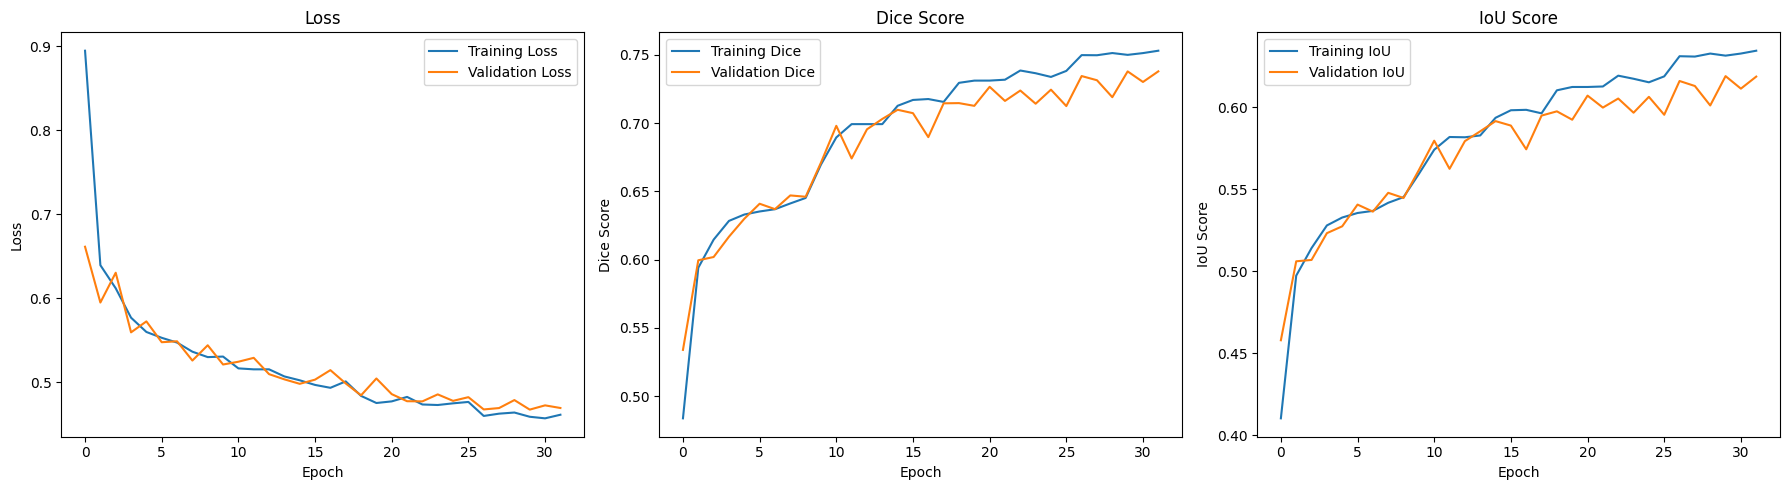

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0     0.9288    0.9134    0.9210  13466604
     Class 1     0.4524    0.4341    0.4430    787225
     Class 2     0.7443    0.7873    0.7651   5649153
     Class 3     0.9044    0.9038    0.9041   7818741
     Class 4     0.7039    0.6268    0.6631    619594
     Class 5     0.6467    0.7305    0.6860    169510
     Class 6     0.9841    0.9965    0.9902   5271570
     Class 7     0.6862    0.4228    0.5232     21455

   micro avg     0.8834    0.8854    0.8844  33803852
   macro avg     0.7563    0.7269    0.7370  33803852
weighted avg     0.8842    0.8854    0.8846  33803852

=== Dice per Class ===
0: 0.9210
1: 0.4430
2: 0.7651
3: 0.9041
4: 0.6631
5: 0.6860
6: 0.9902
7: 0.5232

=== IoU per Class ===
0: 0.8537
1: 0.2845
2: 0.6196
3: 0.8250
4: 0.4960
5: 0.5221
6: 0.9807
7: 0.3543

 === Overall Performance === 
Macro-Dice: 0.7370
Macro-IoU : 0.6170


In [ ]:
unet = model.UNet(num_classes=8)
unet = unet.to(device)
for enc in (unet.encoder0, unet.encoder1, unet.encoder2, unet.encoder3, unet.encoder4):
    for p in enc.parameters():
        p.requires_grad = False
    for m in enc.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()


ds_train = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
)
ds_valid = DataLoader(val_dataset, batch_size=32, shuffle=False)
ds_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

dec_lr = 1e-3

optimizer = optim.Adam(
    [
        {"params": unet.bottleneck.parameters(), "lr": dec_lr},
        {"params": unet.decoder_1.parameters(), "lr": dec_lr},
        {"params": unet.decoder_2.parameters(), "lr": dec_lr},
        {"params": unet.decoder_3.parameters(), "lr": dec_lr},
        {"params": unet.decoder_4.parameters(), "lr": dec_lr},
        {"params": unet.decoder_5.parameters(), "lr": dec_lr},  # ← add this line
        {"params": unet.final.parameters(), "lr": dec_lr},
    ],
    weight_decay=1e-4,
)


criterion = HybridLoss(a=0.5)

# Train the model
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2,
)
# Train the model
train_losses, val_losses, train_dice, val_dice, train_iou, val_iou = t.train_model(
    model=unet,
    train_loader=ds_train,
    val_loader=ds_valid,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=100,
    save_name="output/hybrid_loss.pt",
)

# Evaluate
t.plot_history(train_losses, val_losses, train_dice, val_dice, train_iou, val_iou)
t.segmentation_report(unet, ds_valid)

#### 2nd Experiment: Fine Tuning Model with hybrid loss

In [ ]:
# Train only the decoder of Unet
unet = model.UNet(num_classes=8)
unet = unet.to(device)

ds_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
ds_valid = DataLoader(val_dataset, batch_size=32, shuffle=False)
ds_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

for param in unet.encoder0.parameters():
    param.requires_grad = False

for param in unet.encoder1.parameters():
    param.requires_grad = False


enc_lr = 1e-4  # lower learning rate for pretrained encoder
dec_lr = 1e-3  # higher for decoder


optimizer = optim.Adam(
    [
        {"params": unet.encoder2.parameters(), "lr": enc_lr},
        {"params": unet.encoder3.parameters(), "lr": enc_lr},
        {"params": unet.encoder4.parameters(), "lr": enc_lr},
        {"params": unet.bottleneck.parameters(), "lr": dec_lr},
        {"params": unet.decoder_1.parameters(), "lr": dec_lr},
        {"params": unet.decoder_2.parameters(), "lr": dec_lr},
        {"params": unet.decoder_3.parameters(), "lr": dec_lr},
        {"params": unet.decoder_4.parameters(), "lr": dec_lr},
        {"params": unet.decoder_5.parameters(), "lr": dec_lr},
        {"params": unet.final.parameters(), "lr": dec_lr},
    ]
)


scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2,
)

criterion = HybridLoss(a=0.5)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice = (
    t.train_model(
        model=unet,
        train_loader=ds_train,
        val_loader=ds_valid,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        save_name="output/fine_tuning.pt",
        num_epochs=100,
    )
)

# Evaluate
t.plot_history(train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice)
t.segmentation_report(unet, ds_test)

Epoch 1/100 [Val]: 100%|██████████| 17/17 [00:07<00:00,  2.31it/s]


Epoch 1/100 | Train Loss: 0.8952 | Train Dice: 0.4768 || Train IoU: 0.4088 || Val Loss: 0.6375 | Val Dice: 0.5707 |Val IoU: 0.4855  
New best loss: 0.6375


Epoch 2/100 [Val]: 100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch 2/100 | Train Loss: 0.6286 | Train Dice: 0.6049 || Train IoU: 0.5066 || Val Loss: 0.5744 | Val Dice: 0.6022 |Val IoU: 0.5091  
New best loss: 0.5744


Epoch 3/100 [Val]: 100%|██████████| 17/17 [00:04<00:00,  4.17it/s]


Epoch 3/100 | Train Loss: 0.5771 | Train Dice: 0.6313 || Train IoU: 0.5317 || Val Loss: 0.5637 | Val Dice: 0.6276 |Val IoU: 0.5285  
New best loss: 0.5637


Epoch 4/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch 4/100 | Train Loss: 0.5508 | Train Dice: 0.6373 || Train IoU: 0.5375 || Val Loss: 0.5275 | Val Dice: 0.6397 |Val IoU: 0.5404  
New best loss: 0.5275


Epoch 5/100 [Val]: 100%|██████████| 17/17 [00:04<00:00,  4.17it/s]


Epoch 5/100 | Train Loss: 0.5348 | Train Dice: 0.6465 || Train IoU: 0.5470 || Val Loss: 0.5086 | Val Dice: 0.6522 |Val IoU: 0.5525  
New best loss: 0.5086


Epoch 6/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  4.31it/s]


Epoch 6/100 | Train Loss: 0.5273 | Train Dice: 0.6481 || Train IoU: 0.5484 || Val Loss: 0.5056 | Val Dice: 0.6452 |Val IoU: 0.5465  
New best loss: 0.5056


Epoch 7/100 [Val]: 100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Epoch 7/100 | Train Loss: 0.5280 | Train Dice: 0.6484 || Train IoU: 0.5487 || Val Loss: 0.5245 | Val Dice: 0.6462 |Val IoU: 0.5465  
 No improvement (1/5)


Epoch 8/100 [Val]: 100%|██████████| 17/17 [00:03<00:00,  4.44it/s]


Epoch 8/100 | Train Loss: 0.5084 | Train Dice: 0.6567 || Train IoU: 0.5571 || Val Loss: 0.5048 | Val Dice: 0.6594 |Val IoU: 0.5536  
 No improvement (2/5)


Epoch 9/100 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.81it/s]


Epoch 9/100 | Train Loss: 0.4995 | Train Dice: 0.6897 || Train IoU: 0.5779 || Val Loss: 0.4975 | Val Dice: 0.7030 |Val IoU: 0.5842  
New best loss: 0.4975


Epoch 10/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch 10/100 | Train Loss: 0.4890 | Train Dice: 0.7069 || Train IoU: 0.5913 || Val Loss: 0.4861 | Val Dice: 0.7156 |Val IoU: 0.5961  
New best loss: 0.4861


Epoch 11/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch 11/100 | Train Loss: 0.4819 | Train Dice: 0.7136 || Train IoU: 0.5971 || Val Loss: 0.4803 | Val Dice: 0.7206 |Val IoU: 0.6007  
New best loss: 0.4803


Epoch 12/100 [Val]: 100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch 12/100 | Train Loss: 0.4781 | Train Dice: 0.7221 || Train IoU: 0.6046 || Val Loss: 0.4717 | Val Dice: 0.7172 |Val IoU: 0.6000  
New best loss: 0.4717


Epoch 13/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch 13/100 | Train Loss: 0.4767 | Train Dice: 0.7313 || Train IoU: 0.6123 || Val Loss: 0.4686 | Val Dice: 0.7185 |Val IoU: 0.6008  
New best loss: 0.4686


Epoch 14/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch 14/100 | Train Loss: 0.4721 | Train Dice: 0.7277 || Train IoU: 0.6097 || Val Loss: 0.4673 | Val Dice: 0.7365 |Val IoU: 0.6192  
New best loss: 0.4673


Epoch 15/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch 15/100 | Train Loss: 0.4685 | Train Dice: 0.7372 || Train IoU: 0.6179 || Val Loss: 0.4717 | Val Dice: 0.7270 |Val IoU: 0.6073  
 No improvement (1/5)


Epoch 16/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch 16/100 | Train Loss: 0.4606 | Train Dice: 0.7461 || Train IoU: 0.6267 || Val Loss: 0.4664 | Val Dice: 0.7282 |Val IoU: 0.6095  
 No improvement (2/5)


Epoch 17/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch 17/100 | Train Loss: 0.4642 | Train Dice: 0.7432 || Train IoU: 0.6243 || Val Loss: 0.4530 | Val Dice: 0.7337 |Val IoU: 0.6155  
New best loss: 0.4530


Epoch 18/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch 18/100 | Train Loss: 0.4577 | Train Dice: 0.7409 || Train IoU: 0.6224 || Val Loss: 0.4772 | Val Dice: 0.7358 |Val IoU: 0.6145  
 No improvement (1/5)


Epoch 19/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch 19/100 | Train Loss: 0.4551 | Train Dice: 0.7446 || Train IoU: 0.6260 || Val Loss: 0.4517 | Val Dice: 0.7401 |Val IoU: 0.6224  
New best loss: 0.4517


Epoch 20/100 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.42it/s]


Epoch 20/100 | Train Loss: 0.4550 | Train Dice: 0.7376 || Train IoU: 0.6200 || Val Loss: 0.4459 | Val Dice: 0.7437 |Val IoU: 0.6262  
New best loss: 0.4459


Epoch 21/100 [Val]: 100%|██████████| 17/17 [00:06<00:00,  2.72it/s]


Epoch 21/100 | Train Loss: 0.4486 | Train Dice: 0.7524 || Train IoU: 0.6339 || Val Loss: 0.4489 | Val Dice: 0.7361 |Val IoU: 0.6175  
 No improvement (1/5)


Epoch 22/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.31it/s]


Epoch 22/100 | Train Loss: 0.4458 | Train Dice: 0.7535 || Train IoU: 0.6351 || Val Loss: 0.4438 | Val Dice: 0.7441 |Val IoU: 0.6254  
New best loss: 0.4438


Epoch 23/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch 23/100 | Train Loss: 0.4441 | Train Dice: 0.7589 || Train IoU: 0.6406 || Val Loss: 0.4598 | Val Dice: 0.7307 |Val IoU: 0.6117  
 No improvement (1/5)


Epoch 24/100 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.99it/s]


Epoch 24/100 | Train Loss: 0.4418 | Train Dice: 0.7553 || Train IoU: 0.6371 || Val Loss: 0.4459 | Val Dice: 0.7540 |Val IoU: 0.6355  
 No improvement (2/5)


Epoch 25/100 [Val]: 100%|██████████| 17/17 [00:06<00:00,  2.57it/s]


Epoch 25/100 | Train Loss: 0.4385 | Train Dice: 0.7511 || Train IoU: 0.6334 || Val Loss: 0.4401 | Val Dice: 0.7435 |Val IoU: 0.6250  
New best loss: 0.4401


Epoch 26/100 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.73it/s]


Epoch 26/100 | Train Loss: 0.4367 | Train Dice: 0.7636 || Train IoU: 0.6459 || Val Loss: 0.4396 | Val Dice: 0.7479 |Val IoU: 0.6292  
 No improvement (1/5)


Epoch 27/100 [Val]: 100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch 27/100 | Train Loss: 0.4360 | Train Dice: 0.7583 || Train IoU: 0.6400 || Val Loss: 0.4427 | Val Dice: 0.7591 |Val IoU: 0.6410  
 No improvement (2/5)


Epoch 28/100 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


Epoch 28/100 | Train Loss: 0.4345 | Train Dice: 0.7643 || Train IoU: 0.6467 || Val Loss: 0.4439 | Val Dice: 0.7483 |Val IoU: 0.6300  
 No improvement (3/5)


Epoch 29/100 [Val]: 100%|██████████| 17/17 [00:06<00:00,  2.67it/s]


Epoch 29/100 | Train Loss: 0.4263 | Train Dice: 0.7706 || Train IoU: 0.6534 || Val Loss: 0.4340 | Val Dice: 0.7600 |Val IoU: 0.6423  
New best loss: 0.4340


Epoch 30/100 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.77it/s]


Epoch 30/100 | Train Loss: 0.4298 | Train Dice: 0.7640 || Train IoU: 0.6460 || Val Loss: 0.4448 | Val Dice: 0.7452 |Val IoU: 0.6264  
 No improvement (1/5)


Epoch 31/100 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.66it/s]


Epoch 31/100 | Train Loss: 0.4253 | Train Dice: 0.7691 || Train IoU: 0.6518 || Val Loss: 0.4400 | Val Dice: 0.7473 |Val IoU: 0.6287  
 No improvement (2/5)


Epoch 32/100 [Val]: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch 32/100 | Train Loss: 0.4260 | Train Dice: 0.7546 || Train IoU: 0.6378 || Val Loss: 0.4538 | Val Dice: 0.7379 |Val IoU: 0.6195  
 No improvement (3/5)


Epoch 33/100 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


Epoch 33/100 | Train Loss: 0.4174 | Train Dice: 0.7677 || Train IoU: 0.6506 || Val Loss: 0.4257 | Val Dice: 0.7619 |Val IoU: 0.6458  
New best loss: 0.4257


Epoch 34/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch 34/100 | Train Loss: 0.4135 | Train Dice: 0.7777 || Train IoU: 0.6615 || Val Loss: 0.4247 | Val Dice: 0.7550 |Val IoU: 0.6375  
 No improvement (1/5)


Epoch 35/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch 35/100 | Train Loss: 0.4109 | Train Dice: 0.7793 || Train IoU: 0.6634 || Val Loss: 0.4283 | Val Dice: 0.7484 |Val IoU: 0.6306  
 No improvement (2/5)


Epoch 36/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch 36/100 | Train Loss: 0.4075 | Train Dice: 0.7786 || Train IoU: 0.6626 || Val Loss: 0.4262 | Val Dice: 0.7560 |Val IoU: 0.6382  
 No improvement (3/5)


Epoch 37/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch 37/100 | Train Loss: 0.4099 | Train Dice: 0.7807 || Train IoU: 0.6650 || Val Loss: 0.4226 | Val Dice: 0.7642 |Val IoU: 0.6473  
New best loss: 0.4226


Epoch 38/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch 38/100 | Train Loss: 0.4093 | Train Dice: 0.7826 || Train IoU: 0.6672 || Val Loss: 0.4193 | Val Dice: 0.7625 |Val IoU: 0.6460  
New best loss: 0.4193


Epoch 39/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch 39/100 | Train Loss: 0.4066 | Train Dice: 0.7847 || Train IoU: 0.6697 || Val Loss: 0.4209 | Val Dice: 0.7616 |Val IoU: 0.6442  
 No improvement (1/5)


Epoch 40/100 [Val]: 100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch 40/100 | Train Loss: 0.4060 | Train Dice: 0.7827 || Train IoU: 0.6673 || Val Loss: 0.4246 | Val Dice: 0.7584 |Val IoU: 0.6412  
 No improvement (2/5)


Epoch 41/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.39it/s]


Epoch 41/100 | Train Loss: 0.4042 | Train Dice: 0.7835 || Train IoU: 0.6681 || Val Loss: 0.4252 | Val Dice: 0.7578 |Val IoU: 0.6405  
 No improvement (3/5)


Epoch 42/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch 42/100 | Train Loss: 0.3980 | Train Dice: 0.7878 || Train IoU: 0.6733 || Val Loss: 0.4175 | Val Dice: 0.7633 |Val IoU: 0.6462  
New best loss: 0.4175


Epoch 43/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.35it/s]


Epoch 43/100 | Train Loss: 0.4002 | Train Dice: 0.7901 || Train IoU: 0.6760 || Val Loss: 0.4177 | Val Dice: 0.7715 |Val IoU: 0.6555  
 No improvement (1/5)


Epoch 44/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.28it/s]


Epoch 44/100 | Train Loss: 0.3991 | Train Dice: 0.7902 || Train IoU: 0.6761 || Val Loss: 0.4147 | Val Dice: 0.7686 |Val IoU: 0.6520  
New best loss: 0.4147


Epoch 45/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch 45/100 | Train Loss: 0.3942 | Train Dice: 0.7899 || Train IoU: 0.6758 || Val Loss: 0.4174 | Val Dice: 0.7636 |Val IoU: 0.6470  
 No improvement (1/5)


Epoch 46/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.25it/s]


Epoch 46/100 | Train Loss: 0.3963 | Train Dice: 0.7912 || Train IoU: 0.6773 || Val Loss: 0.4211 | Val Dice: 0.7585 |Val IoU: 0.6420  
 No improvement (2/5)


Epoch 47/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.38it/s]


Epoch 47/100 | Train Loss: 0.3911 | Train Dice: 0.7918 || Train IoU: 0.6780 || Val Loss: 0.4179 | Val Dice: 0.7638 |Val IoU: 0.6476  
 No improvement (3/5)


Epoch 48/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch 48/100 | Train Loss: 0.3901 | Train Dice: 0.7940 || Train IoU: 0.6806 || Val Loss: 0.4169 | Val Dice: 0.7673 |Val IoU: 0.6508  
 No improvement (4/5)


Epoch 49/100 [Val]: 100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


Epoch 49/100 | Train Loss: 0.3905 | Train Dice: 0.7943 || Train IoU: 0.6808 || Val Loss: 0.4169 | Val Dice: 0.7680 |Val IoU: 0.6514  
 No improvement (5/5)
Early stopping triggered.


NameError: name 'train_iou' is not defined

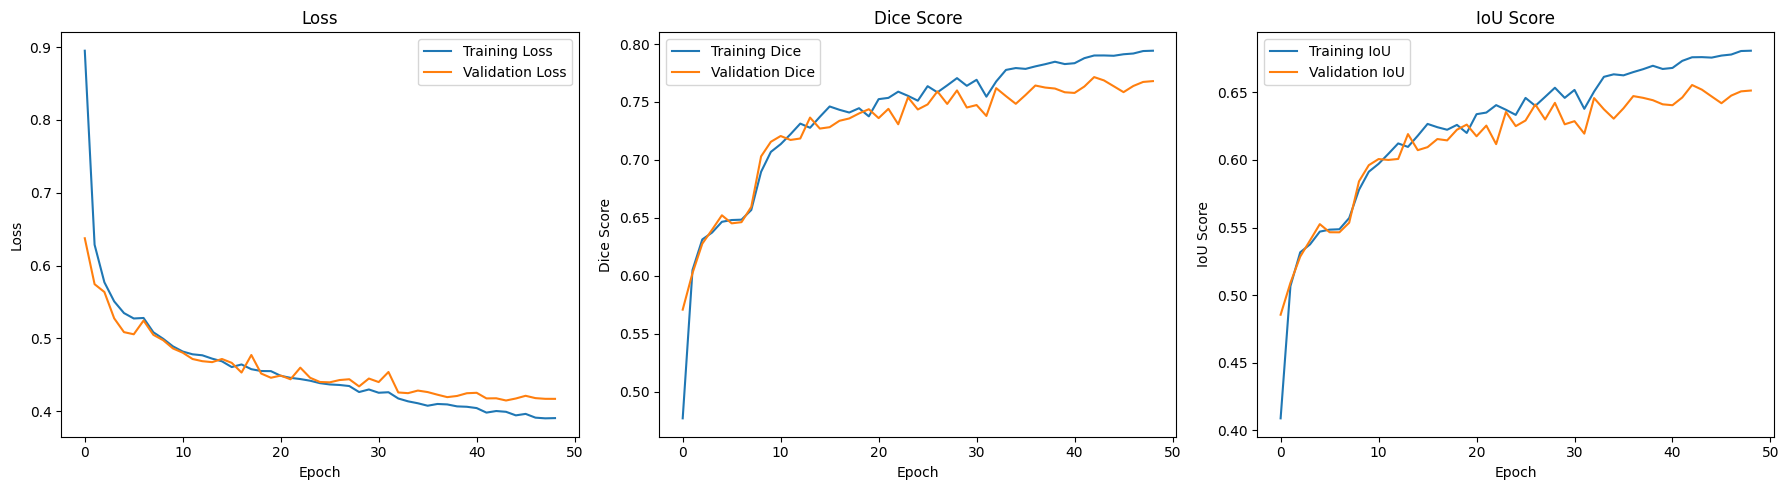

=== Classification Report ===
              precision    recall  f1-score   support

     Class 0     0.9230    0.9373    0.9301   8362236
     Class 1     0.5046    0.4002    0.4464    480926
     Class 2     0.7836    0.7648    0.7741   3475778
     Class 3     0.9092    0.9190    0.9140   5691665
     Class 4     0.7053    0.6968    0.7010    433918
     Class 5     0.6593    0.7291    0.6924    110535
     Class 6     0.9930    0.9970    0.9950   4077148
     Class 7     0.7981    0.5979    0.6836     16305

   micro avg     0.8986    0.8997    0.8992  22648511
   macro avg     0.7845    0.7553    0.7671  22648511
weighted avg     0.8963    0.8997    0.8978  22648511

=== Dice per Class ===
0: 0.9301
1: 0.4464
2: 0.7741
3: 0.9140
4: 0.7010
5: 0.6924
6: 0.9950
7: 0.6836

=== IoU per Class ===
0: 0.8693
1: 0.2873
2: 0.6314
3: 0.8417
4: 0.5397
5: 0.5295
6: 0.9901
7: 0.5193

 === Overall Performance === 
Macro-Dice: 0.7671
Macro-IoU : 0.6510


In [12]:
t.plot_history(train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice)
t.segmentation_report(unet, ds_test)

dice loss

In [ ]:
# Train only the decoder of Unet
unet = model.UNet(num_classes=8)
unet = unet.to(device)

ds_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
ds_valid = DataLoader(val_dataset, batch_size=32, shuffle=False)
ds_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

for param in unet.encoder0.parameters():
    param.requires_grad = False

for param in unet.encoder1.parameters():
    param.requires_grad = False


enc_lr = 1e-5  # lower learning rate for pretrained encoder
dec_lr = 1e-4  # higher for decoder


optimizer = optim.Adam(
    [
        {"params": unet.encoder2.parameters(), "lr": enc_lr},
        {"params": unet.encoder3.parameters(), "lr": enc_lr},
        {"params": unet.encoder4.parameters(), "lr": enc_lr},
        {"params": unet.bottleneck.parameters(), "lr": dec_lr},
        {"params": unet.decoder_1.parameters(), "lr": dec_lr},
        {"params": unet.decoder_2.parameters(), "lr": dec_lr},
        {"params": unet.decoder_3.parameters(), "lr": dec_lr},
        {"params": unet.decoder_4.parameters(), "lr": dec_lr},
        {"params": unet.decoder_5.parameters(), "lr": dec_lr},
        {"params": unet.final.parameters(), "lr": dec_lr},
    ]
)


scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2,
)

criterion = smp.losses.DiceLoss(mode="multiclass", from_logits=True, ignore_index=255)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, train_dice, val_dice = (
    t.train_model(
        model=unet,
        train_loader=ds_train,
        val_loader=ds_valid,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        save_name="output/fine_tuning_dice.pt",
        num_epochs=100,
    )
)

# Evaluate
t.plot_history(train_losses, val_losses, train_dice, val_dice, train_iou, val_iou)
t.segmentation_report(unet, ds_test)